## Simulated PSP

In [2]:
# We first import all the modules we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

#### Importing Case Study Data (Ugo)

In [4]:
file_path = 'case_study_data (4).xlsx'
specific_sheets = pd.read_excel(file_path, sheet_name=['Risky asset', 'ZC yields'])
risky_df = specific_sheets['Risky asset']
yields_df = specific_sheets['ZC yields']

In [5]:
yields_df.columns = yields_df.iloc[0]
yields_df = yields_df[2:]
yields_df.set_index('Maturity (years)', inplace=True)
yields_df.index = pd.to_datetime(yields_df.index)
yields_df.index.name = 'Effective date'

In [6]:
risky_df = risky_df.iloc[1:]
risky_df.set_index('Prices', inplace=True)
risky_df.index = pd.to_datetime(risky_df.index)
risky_df.index.name = 'Date'
risky_df.columns = ['Price']

In [7]:
maturities = yields_df.columns.astype(float)
maturities = maturities.values.reshape(-1, 1)  # Reshape to (n_columns, 1)
prices_array = 1 / ((1 + yields_df.values) ** maturities.T)  # T is transposed to match the shape of yields_df
prices_df = pd.DataFrame(prices_array, columns=yields_df.columns, index=yields_df.index)
prices_df.columns = [f"Price_{col}" for col in prices_df.columns]

#### 1- Heston Model for S&P500

In [9]:
# Loading the SPY data for the 2002-2014 period (historical data for mu, sigma and SR)
start_date = "2002-06-21"
end_date = "2014-10-30"
sp500_data = yf.download("SPY", start=start_date, end=end_date)
sp500_data['Daily Return'] = sp500_data['Adj Close'].pct_change().dropna()
mu = np.mean(sp500_data['Daily Return'])
sigma = np.std(sp500_data['Daily Return'])

[*********************100%***********************]  1 of 1 completed


In [10]:
sigma_ann = sigma * np.sqrt(252)
sigma_ann

0.2019639283286636

In [11]:
mu_ann = mu * 252
mu_ann

0.09588643363877453

In [12]:
var_ann = sigma_ann**2
var_ann

0.04078942834594557

In [13]:
sr_ann = mu_ann/sigma_ann
sr_ann

0.4747700959883038

In [14]:
def identity(x):
    return x

def heston_simulate(rate: float, sharpe_ratio: float, initial_price: float,
                    kappa: float, lt_var: float, vol_var: float, initial_var: float, rho: float,
                    n_paths: int, time_step: float, n_periods: int,
                    rng: np.random._generator.Generator,
                    transform=identity):
    """
    Simulate paths for price and volatility under the Heston model.
    rate corresponds to the drift (mu), which can be customized for each factor.
    """
    logS = np.empty((n_periods + 1, n_paths))  # Pre-allocation
    V = np.empty((n_periods + 1, n_paths))
    
    logS[0, :] = np.log(initial_price)  # Initial log price
    V[0, :] = initial_var
    
    loading2 = np.sqrt(1 - rho**2)
    
    for i in range(1, n_periods + 1):
        std_innov1 = rng.standard_normal(n_paths)
        
        sigma = np.sqrt(V[i - 1, :])  # Current volatility
        
        logS[i, :] = logS[i - 1, :] + (rate + sharpe_ratio * sigma - .5 * V[i - 1, :]) * time_step \
            + sigma * np.sqrt(time_step) * std_innov1
            
        std_innov2 = rng.standard_normal(n_paths)
            
        V[i, :] = V[i - 1, :] + kappa * (lt_var - V[i - 1, :]) * time_step \
            + vol_var * sigma * np.sqrt(time_step) * (rho * std_innov1 + loading2 * std_innov2)
            
        # Prevent volatility from becoming negative or too small
        V[i, :] = np.maximum(V[i, :], 1e-6)  # introduce a Floor on volatility
        
        V[i, :] = transform(V[i, :])  # Transform simulated variances
        
    S = np.exp(logS)  # Exponentiate to get the stock price
    
    return {'price': S, 'volatility': np.sqrt(V)}

In [15]:
initial_price =  3679.99 #S&P500 level on 31/10/2024
sharpe_ratio = sr_ann
kappa = 5.07
vol_var = 0.48
rho = -0.7670
lt_var = var_ann
n_paths = 1000
time_step = 1/252
n_periods = 252 * 10

In [16]:
rng = np.random.default_rng(seed=1000)

SV = heston_simulate(rate= mu_ann,
                      sharpe_ratio=sharpe_ratio,
                      initial_price=initial_price,
                      kappa=kappa,
                      lt_var=lt_var,
                      vol_var=vol_var,
                      initial_var=lt_var,
                      rho=rho,
                      n_paths=n_paths,
                      time_step=time_step,
                      n_periods=n_periods,
                      rng=rng)

In [17]:
average_stock_price = np.mean(SV['price'], axis=1)
final_value_mean = average_stock_price[-1]
final_value_mean

22989.770671028156

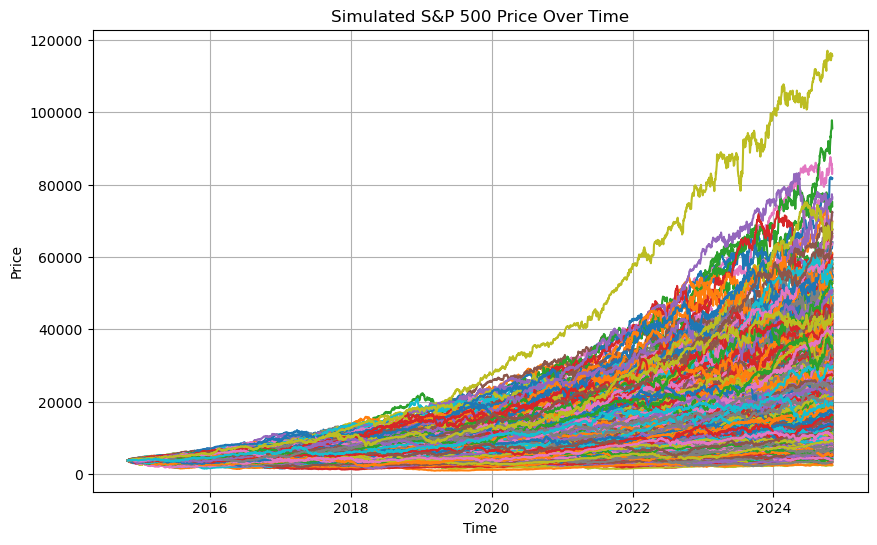

In [18]:
# Plotting it with the respective timeframe (code Ugo)
time= risky_df.index
plt.figure(figsize=(10, 6))
plt.plot(time, SV['price'][:-3])
plt.title("Simulated S&P 500 Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

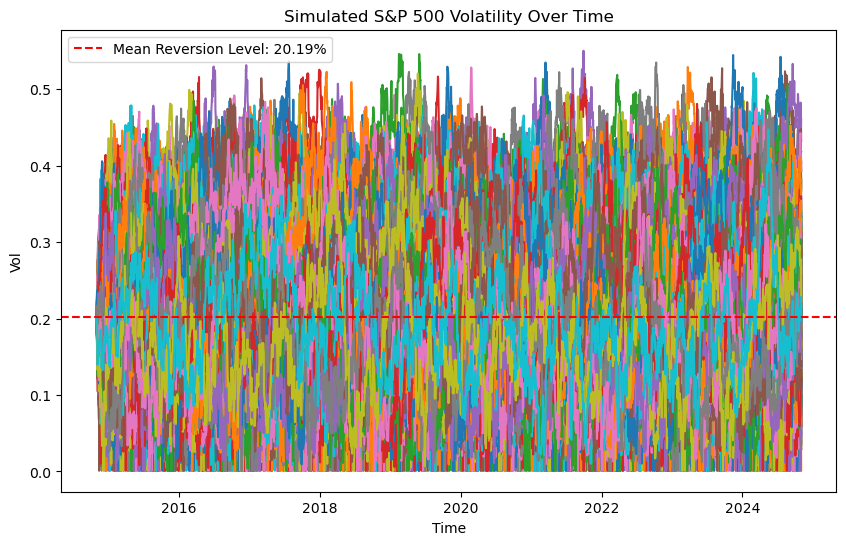

In [19]:
time= risky_df.index
plt.figure(figsize=(10, 6))
plt.plot(time, SV['volatility'][:-3])
plt.title("Simulated S&P 500 Volatility Over Time")
plt.axhline(y=np.sqrt(lt_var), color='r', linestyle='--', label='Mean Reversion Level: 20.19%') 
plt.xlabel("Time")
plt.legend()
plt.ylabel("Vol")
plt.show()

In [20]:
simulated_risky_ret_daily = pd.DataFrame(SV['price']).pct_change().dropna()
simulated_risky_ret_daily

0         1         2         3         4         5         6    \
1    -0.003402 -0.005484  0.022300  0.026085  0.002658 -0.015205  0.003233   
2    -0.002582 -0.006367 -0.012609 -0.016166 -0.009031  0.018210  0.003925   
3     0.008172 -0.010623 -0.006915  0.001133 -0.006471 -0.000889 -0.001183   
4    -0.020574 -0.010059 -0.004526  0.014229 -0.001753 -0.009743  0.010482   
5     0.003167  0.026470  0.010391  0.010943  0.010860  0.001739 -0.004934   
...        ...       ...       ...       ...       ...       ...       ...   
2516 -0.004168  0.003539  0.013296  0.003411 -0.008560 -0.015831 -0.005205   
2517 -0.008526  0.014271 -0.017244  0.013125  0.020763 -0.015356 -0.012471   
2518 -0.017599 -0.010022 -0.017050  0.006513  0.039977 -0.006218  0.027429   
2519 -0.009230 -0.008514  0.011786  0.003226 -0.006634 -0.015573  0.022024   
2520  0.012586 -0.006764  0.011111  0.004900 -0.025369  0.003087 -0.001412   

           7         8         9    ...       990       991       992  \
1     0.001216 -0.010436  0.020342  ... -0.009136  0.024846 -0.008398   
2    -0.010451  0.014898  0.005882  ...  0.000539 -0.009168 -0.005838   
3     0.012400  0.023009 -0.000924  ... -0.003601  0.002740 -0.003074   
4    -0.000774  0.011185 -0.011401  ...  0.020825 -0.011810  0.002322   
5     0.000720  0.027698  0.020555  ... -0.024464  0.002556  0.013715   
...        ...       ...       ...  ...       ...       ...       ...   
2516  0.009785  0.005794 -0.013107  ...  0.005354 -0.004179 -0.023697   
2517 -0.006824  0.008005  0.007488  ...  0.002467  0.006936 -0.004650   
2518  0.001400 -0.001820  0.002736  ...  0.000303  0.004500 -0.008025   
2519  0.022442 -0.003479  0.020774  ...  0.010611  0.002087  0.010618   
2520 -0.013300  0.000877 -0.018379  ... -0.005260 -0.008132 -0.001921   

           993       994       995       996       997       998       999  
1     0.015530  0.022259 -0.000766  0.005403 -0.010911  0.007977  0.005985  
2     0.006585 -0.002430  0.026115  0.008302 -0.005873  0.029245  0.027135  
3     0.003891 -0.011238 -0.014721  0.003712 -0.003555  0.007189 -0.002285  
4     0.003949 -0.007941  0.002925  0.008782  0.015879  0.002850  0.002490  
5     0.001145  0.010155  0.018934 -0.013745  0.004277 -0.004462  0.013331  
...        ...       ...       ...       ...       ...       ...       ...  
2516 -0.004189 -0.014044  0.001392 -0.000618  0.021294  0.002527  0.012017  
2517  0.004335  0.012803  0.006649 -0.012314 -0.016779  0.027114  0.016322  
2518  0.020696 -0.023754  0.019355 -0.001033 -0.008638  0.020894 -0.006382  
2519  0.000630 -0.008443  0.003347 -0.015510  0.018581 -0.015962  0.016318  
2520  0.001605  0.010742 -0.000398  0.017308 -0.004965 -0.013386  0.006159  

[2520 rows x 1000 columns]

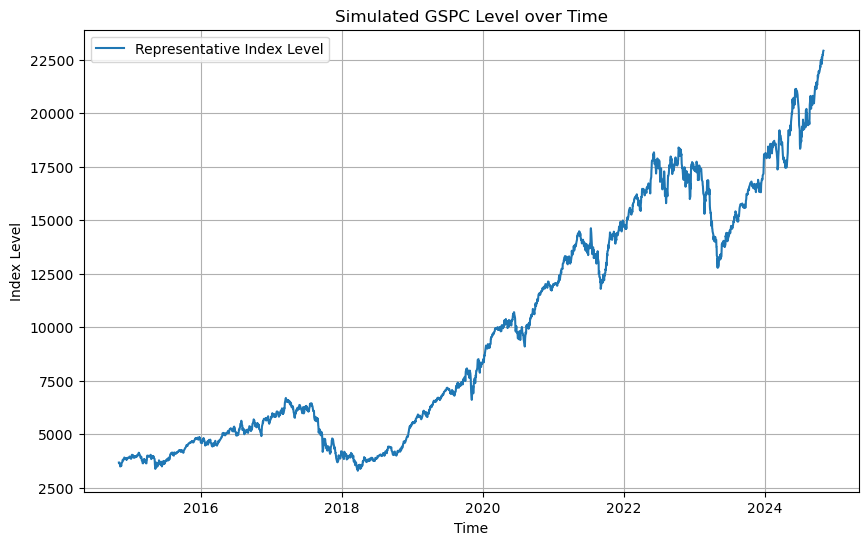

In [21]:
# If we want to plot (representative price)
last_avg_level = np.mean(SV['price'][-1, :])  # Calculate the average final level of all simulated paths
last_levels = SV['price'][-1, :]
differences = np.abs(last_levels - last_avg_level)
closest_path_idx = np.argmin(differences)
representative_stock_price = SV['price'][:, closest_path_idx]

plt.figure(figsize=(10, 6))
plt.plot(time,representative_stock_price[:-3], label='Representative Index Level')
plt.title('Simulated GSPC Level over Time')
plt.xlabel('Time')
plt.ylabel('Index Level')
plt.legend()
plt.grid(True)
plt.show()

#### 2- Heston Model for the 6 factors

In [23]:
# We load every factor data from the Excel file + rename each column -> serve as historical data too
value = pd.read_excel('case_study_data (4).xlsx', sheet_name='Value', skiprows=3, usecols="A:B")
value.rename(columns={'RI(USD)': 'Value'}, inplace=True)
mid_cap = pd.read_excel('case_study_data (4).xlsx', sheet_name='Mid Cap', skiprows=3, usecols="A:B")
mid_cap.rename(columns={'RI(USD)': 'Mid_cap'}, inplace=True)
momentum = pd.read_excel('case_study_data (4).xlsx', sheet_name='Momentum', skiprows=3, usecols="A:B")
momentum.rename(columns={'RI(USD)': 'Momentum'}, inplace=True)
low_vol = pd.read_excel('case_study_data (4).xlsx', sheet_name='Low Volatility ', skiprows=3, usecols="A:B")
low_vol.rename(columns={'RI(USD)': 'Low Vol'}, inplace=True)
low_investment = pd.read_excel('case_study_data (4).xlsx', sheet_name='Low Investment', skiprows=3, usecols="A:B")
low_investment.rename(columns={'RI(USD)': 'Low Investment'}, inplace=True)
high_profitability = pd.read_excel('case_study_data (4).xlsx', sheet_name='High Profitability', skiprows=3, usecols="A:B")
high_profitability.rename(columns={'RI(USD)': 'High Profitability'}, inplace=True)

In [24]:
# Merge the 6 factors into one table only
six_factors = value.merge(mid_cap, on='date')\
                    .merge(momentum, on='date')\
                    .merge(low_vol, on='date')\
                    .merge(low_investment, on='date')\
                    .merge(high_profitability, on='date')

six_factors.set_index('date', inplace=True)
daily_returns = six_factors.pct_change().dropna()
daily_returns_in_sample = daily_returns.loc["2002-06-21":"2014-10-30"]

In [25]:
# Historical mu and sigma of SR, will serve as historical data for estimation
factor_mu = {}
factor_sigma = {}
factor_var = {}
factor_sr = {}

for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    factor_mu[factor] = np.mean(daily_returns_in_sample[factor]) * 252
    factor_sigma[factor] = np.std(daily_returns_in_sample[factor]) * np.sqrt(252)
    factor_var[factor] = factor_sigma[factor] **2 
    factor_sr[factor] = factor_mu[factor]/factor_sigma[factor]

for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    print(f"Facteur: {factor}")
    print(f"Mu : {factor_mu[factor]:.6f}")
    print(f"Sigma : {factor_sigma[factor]:.6f}")
    print(f"Variance : {factor_var[factor]:.6f}")
    print(f"SR : {factor_sr[factor]:.6f}")
    print("---")

Facteur: Value
Mu : 0.126857
Sigma : 0.195982
Variance : 0.038409
SR : 0.647288
---
Facteur: Mid_cap
Mu : 0.128780
Sigma : 0.202136
Variance : 0.040859
SR : 0.637097
---
Facteur: Momentum
Mu : 0.112413
Sigma : 0.198773
Variance : 0.039511
SR : 0.565534
---
Facteur: Low Vol
Mu : 0.114037
Sigma : 0.169858
Variance : 0.028852
SR : 0.671365
---
Facteur: Low Investment
Mu : 0.117254
Sigma : 0.185413
Variance : 0.034378
SR : 0.632393
---
Facteur: High Profitability
Mu : 0.120316
Sigma : 0.188815
Variance : 0.035651
SR : 0.637217
---


In [26]:
# We take here the exact same parameters for the following:
initial_price =  3679.99 #here we'll take the same as S&P500 to compare thereafter
kappa = 5.07
vol_var = 0.48
rho = -0.7670
n_paths = 1000
time_step = 1/252
n_periods = 252 * 10

In [27]:
# And run the heston model with 1000 simul for each factor based on its historic values
SV_factors = {}
for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    sigma_ann = factor_sigma[factor] 
    mu_ann = factor_mu[factor]  
    sr_ann = factor_sr[factor] 
    var_ann = factor_var[factor]
    rng = np.random.default_rng(seed=1000)
    
    SV_factors[factor] = heston_simulate(rate=mu_ann, 
                                         sharpe_ratio=sr_ann, 
                                         initial_price= initial_price,  
                                         kappa=kappa,
                                         lt_var=var_ann, 
                                         vol_var=vol_var,
                                         initial_var=var_ann,
                                         rho=rho,
                                         n_paths=n_paths,
                                         time_step=time_step,
                                         n_periods=n_periods,
                                         rng=rng)

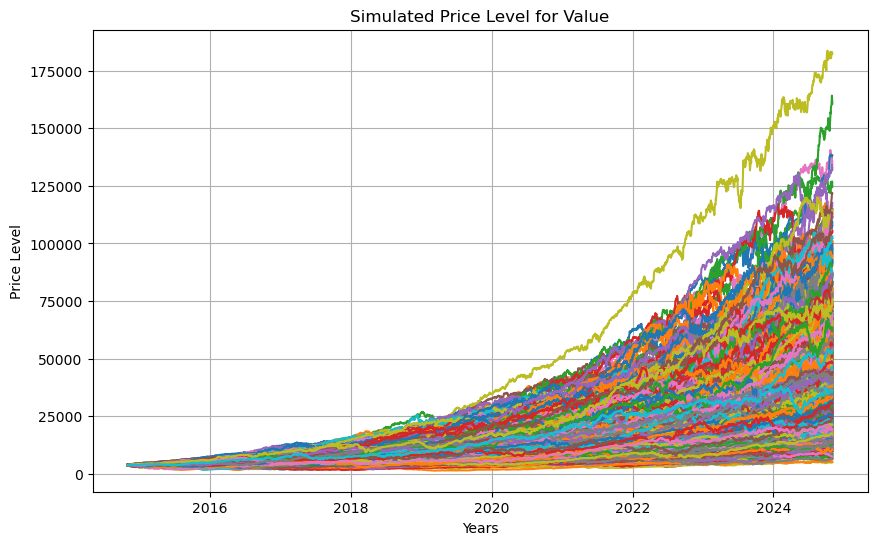

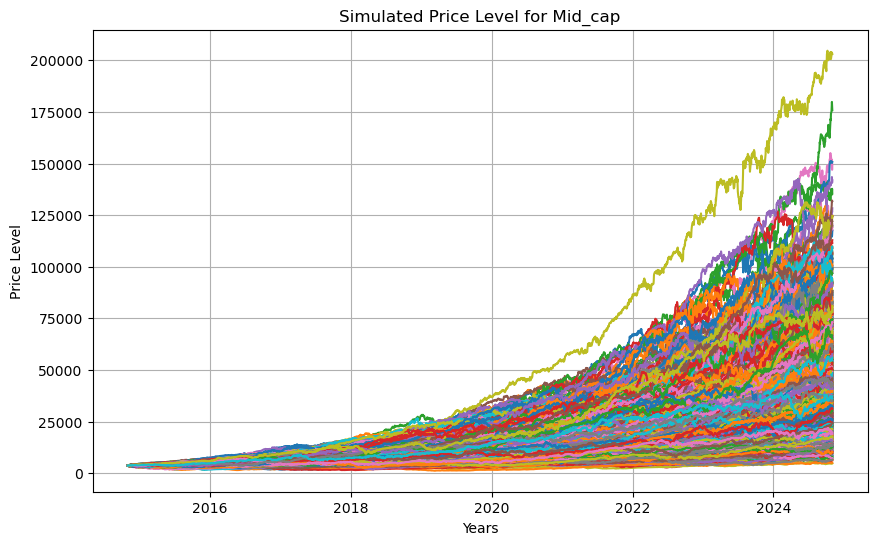

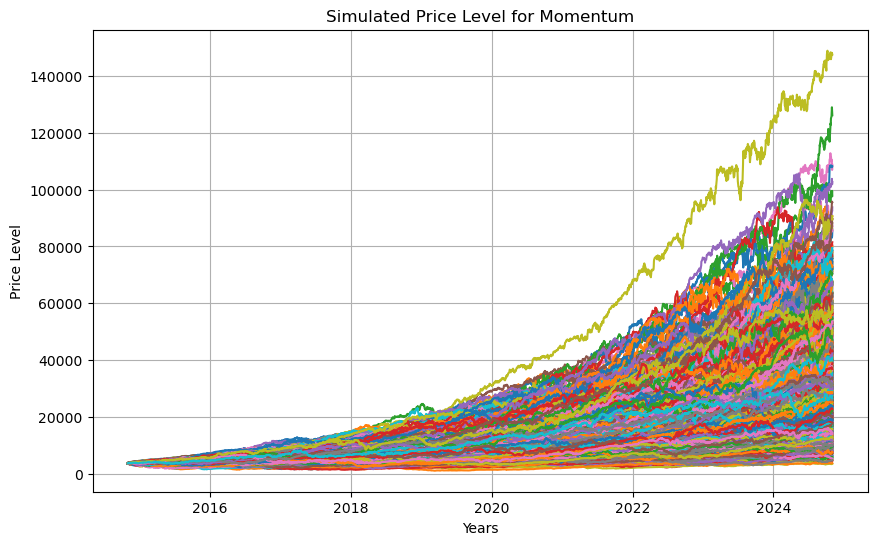

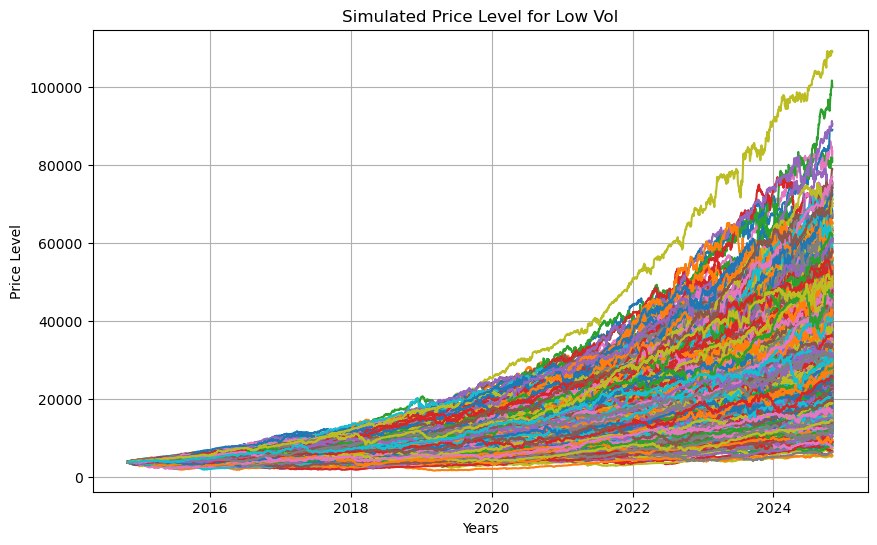

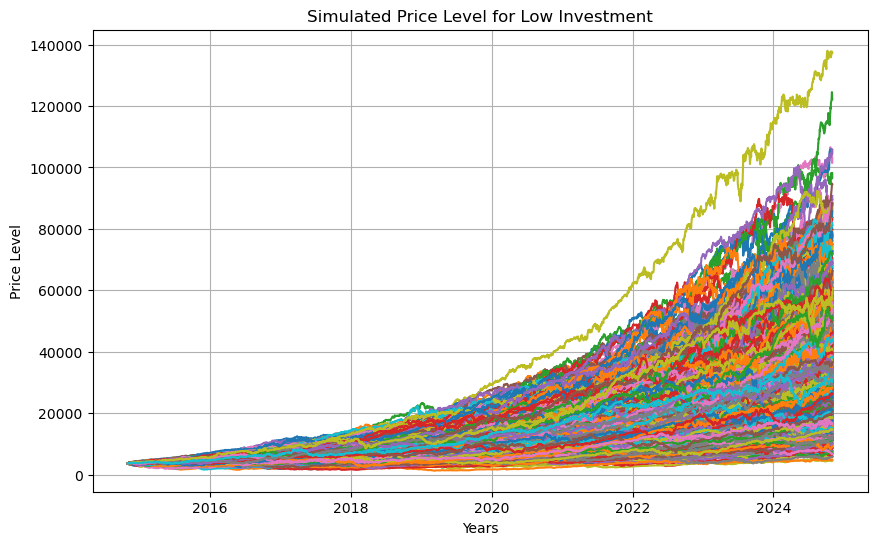

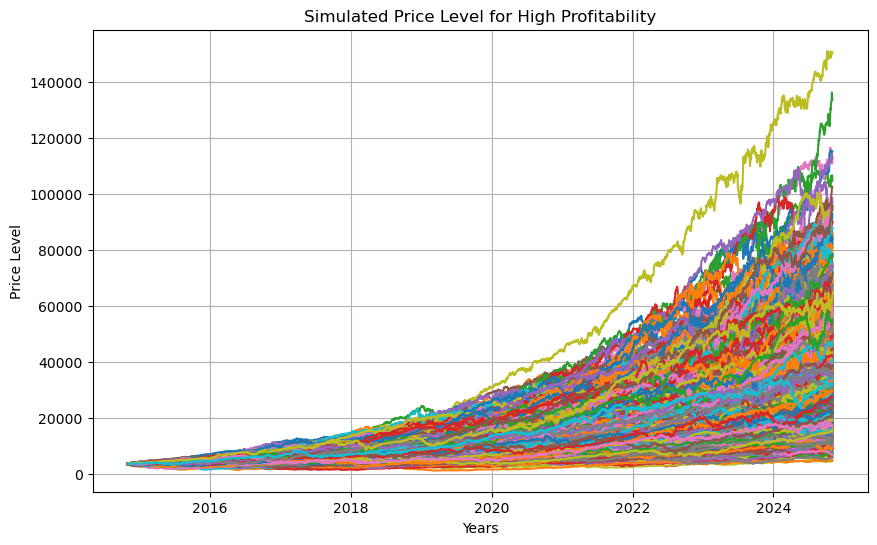

In [28]:
for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    plt.figure(figsize=(10, 6))
    plt.plot(time, SV_factors[factor]['price'][:-3], label=f'{factor} Simulated Price')
    plt.title(f'Simulated Price Level for {factor}') 
    plt.xlabel('Years')
    plt.ylabel('Price Level')
    plt.grid(True)
    plt.show() # they are still very similar

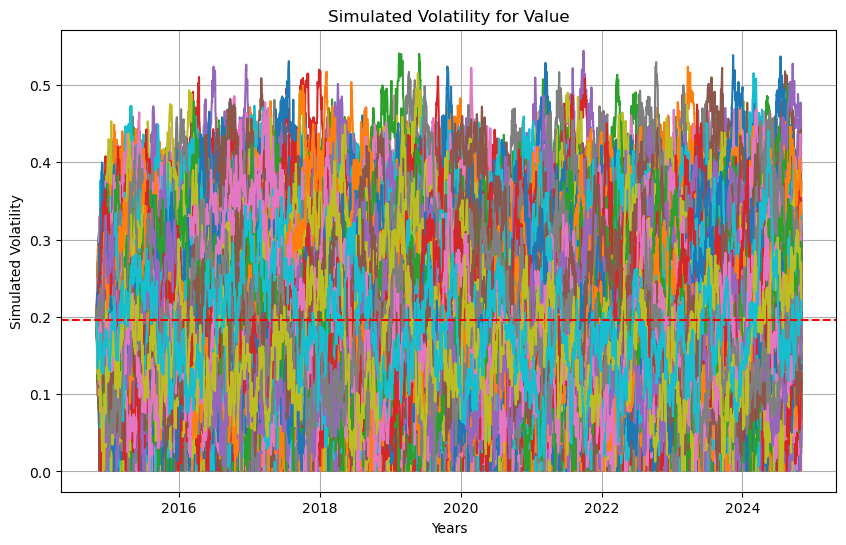

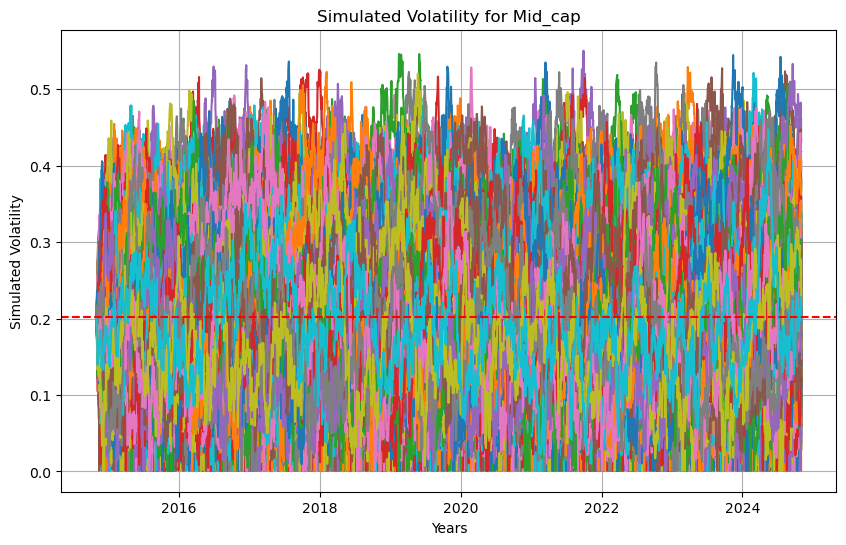

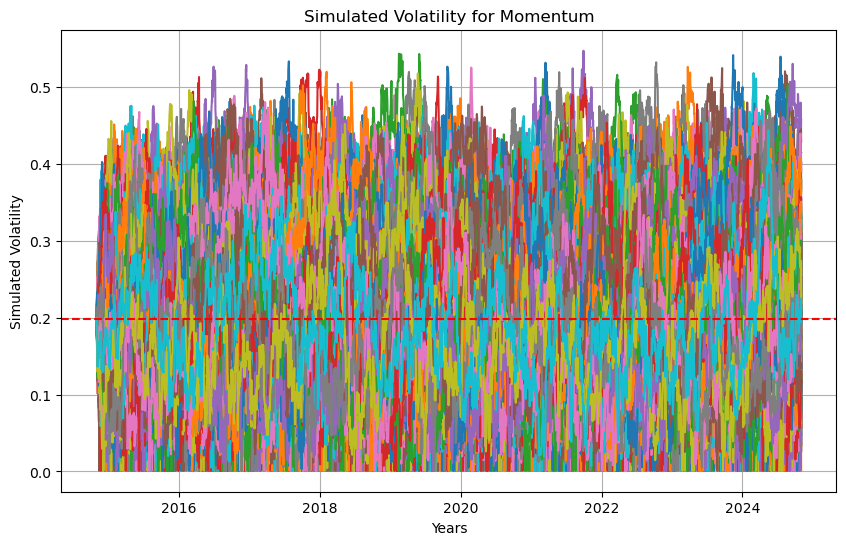

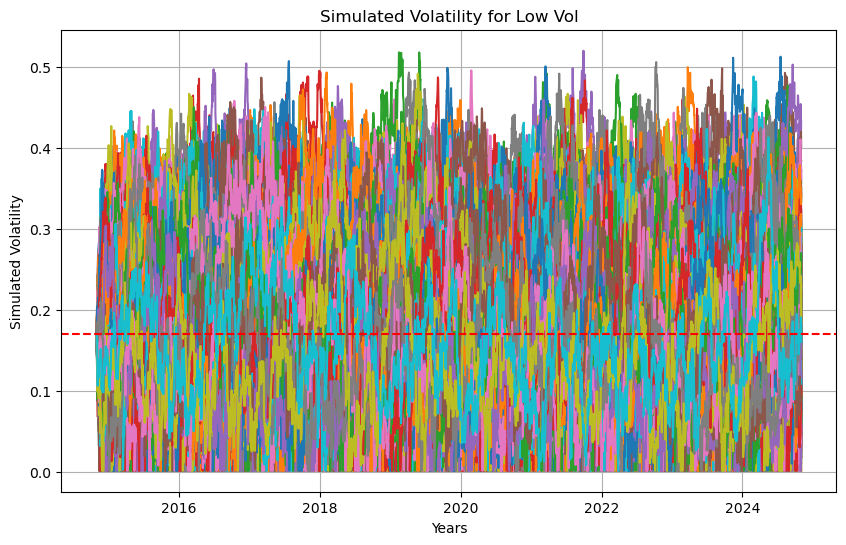

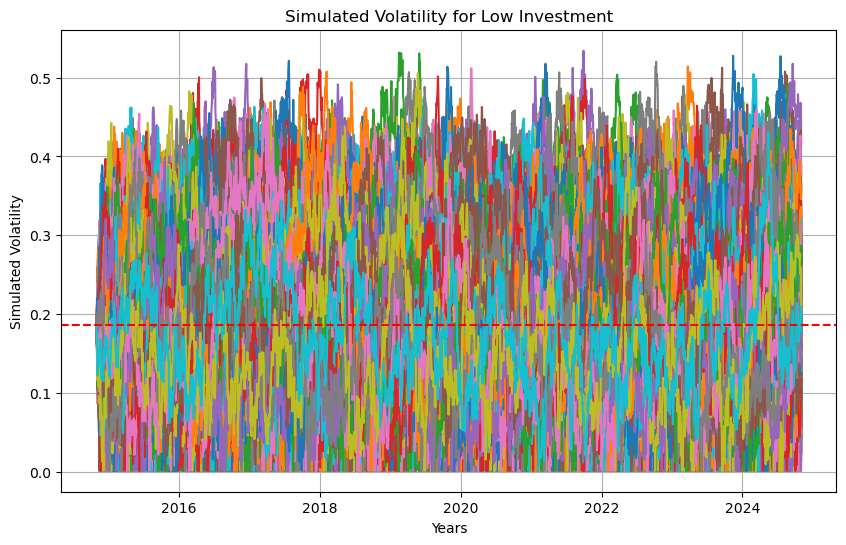

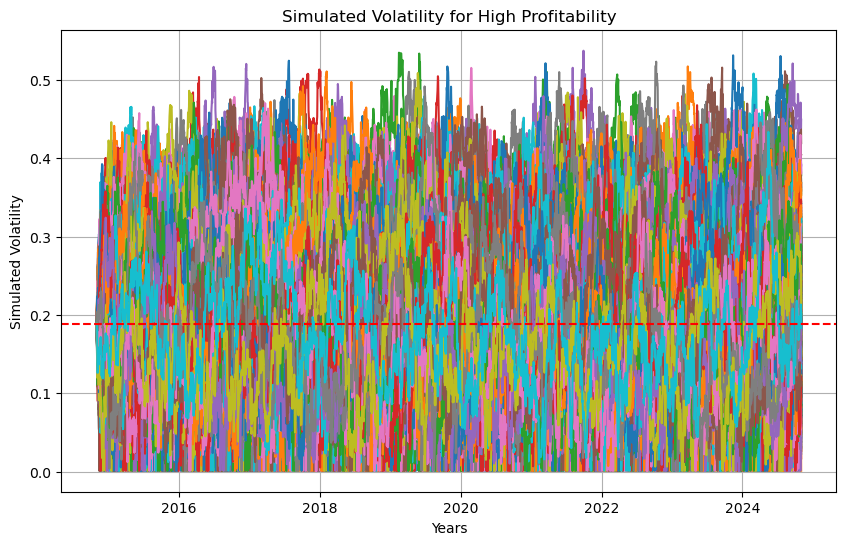

In [29]:
for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    plt.figure(figsize=(10, 6))
    plt.plot(time, SV_factors[factor]['volatility'][:-3], label=f'{factor} Simulated Volatility')
    plt.title(f'Simulated Volatility for {factor}') 
    plt.axhline(y=factor_sigma[factor], color='r', linestyle='--', label='Mean Reversion Level') 
    plt.xlabel('Years')
    plt.ylabel('Simulated Volatility')
    plt.grid(True)
    plt.show()    

In [30]:
mean_paths = {}
for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    mean_paths[factor] = np.mean(SV_factors[factor]['price'], axis=1) 

In [31]:
# taking the final value for each factor (comparison: final value of SP500 around 22K
final_values = {}

for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    final_values[factor] = mean_paths[factor][-1]
    print(f"Final value for {factor}: {final_values[factor]:.2f}")

Final value for Value: 41233.96
Final value for Mid_cap: 43011.14
Final value for Momentum: 31407.24
Final value for Low Vol: 31504.58
Final value for Low Investment: 34022.09
Final value for High Profitability: 36174.11


In [32]:
# Creating the simulated_ret_daily for all 6 factors:
simulated_factor_ret_daily = {}
for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    simulated_factor_ret_daily[factor] = pd.DataFrame(SV_factors[factor]['price']).pct_change().dropna()

simulated_factor_ret_daily # we have a simulated ret daily for all factors

{'Value':            0         1         2         3         4         5         6    \
 1    -0.003032 -0.005052  0.021909  0.025580  0.002851 -0.014491  0.003408   
 2    -0.002235 -0.005912 -0.011918 -0.015372 -0.008485  0.017957  0.004068   
 3     0.008218 -0.010060 -0.006432  0.001363 -0.006008 -0.000598 -0.000887   
 4    -0.019701 -0.009514 -0.004120  0.014007 -0.001432 -0.009182  0.010353   
 5     0.003351  0.026131  0.010330  0.010740  0.010775  0.001973 -0.004504   
 ...        ...       ...       ...       ...       ...       ...       ...   
 2516 -0.003761  0.003659  0.013224  0.003495 -0.008049 -0.015029 -0.004772   
 2517 -0.007979  0.013984 -0.016467  0.012856  0.020728 -0.014612 -0.011849   
 2518 -0.016784 -0.009383 -0.016303  0.006477  0.039561 -0.005748  0.027067   
 2519 -0.008677 -0.007957  0.011797  0.003291 -0.006166 -0.014804  0.021727   
 2520  0.012519 -0.006271  0.011097  0.004854 -0.024530  0.003291 -0.001095   
 
            7         8         9    ... 

In [33]:
# Weights of our fixed FRP:
weights = np.array([0.13672518, 0.13400082, 0.13663591, 0.25, 0.1426381 , 0.2])
simulated_weighted_factor_ret_daily = {}

for i, factor in enumerate(['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']):
    simulated_weighted_factor_ret_daily[factor] = simulated_factor_ret_daily[factor].values * weights[i]

simulated_weighted_factor_ret_daily # so here we have a set a 6 x 2520x1000 array for our ptf with all factors decomposed
# these are all weighted -> representative of the ptf then

{'Value': array([[-0.00041453, -0.0006908 ,  0.00299547, ..., -0.00141124,
          0.00109555,  0.00083116],
        [-0.0003056 , -0.00080832, -0.00162952, ..., -0.00074257,
          0.00389917,  0.00363064],
        [ 0.00112366, -0.00137551, -0.00087941, ..., -0.00043478,
          0.00096849, -0.00026682],
        ...,
        [-0.00229478, -0.00128295, -0.00222904, ..., -0.00110527,
          0.00281006, -0.00080576],
        [-0.00118636, -0.00108789,  0.00161296, ...,  0.00250144,
         -0.00206715,  0.00219415],
        [ 0.00171167, -0.00085745,  0.00151727, ..., -0.00061855,
         -0.00173143,  0.00085203]]),
 'Mid_cap': array([[-0.00042152, -0.00070074,  0.00302641, ..., -0.00142881,
          0.00110503,  0.00083772],
        [-0.00031132, -0.00081822, -0.00165947, ..., -0.00075272,
          0.0039567 ,  0.00367443],
        [ 0.00113195, -0.00138772, -0.00089406, ..., -0.00044178,
          0.0009939 , -0.00027656],
        ...,
        [-0.00232528, -0.00131253,

In [34]:
# To get daily returns of our ptf: loop through each factor & compute weighted returns
portfolio_returns_daily = np.zeros(simulated_factor_ret_daily['Value'].shape[0])

for i, factor in enumerate(['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']):
    portfolio_returns_daily += simulated_factor_ret_daily[factor].values.mean(axis=1) * weights[i]

portfolio_returns_daily_df = pd.DataFrame(portfolio_returns_daily, columns=["Portfolio Returns"])
portfolio_returns_daily_df.head()

Portfolio Returns
0           0.000812
1           0.000964
2           0.000718
3           0.000941
4           0.001217

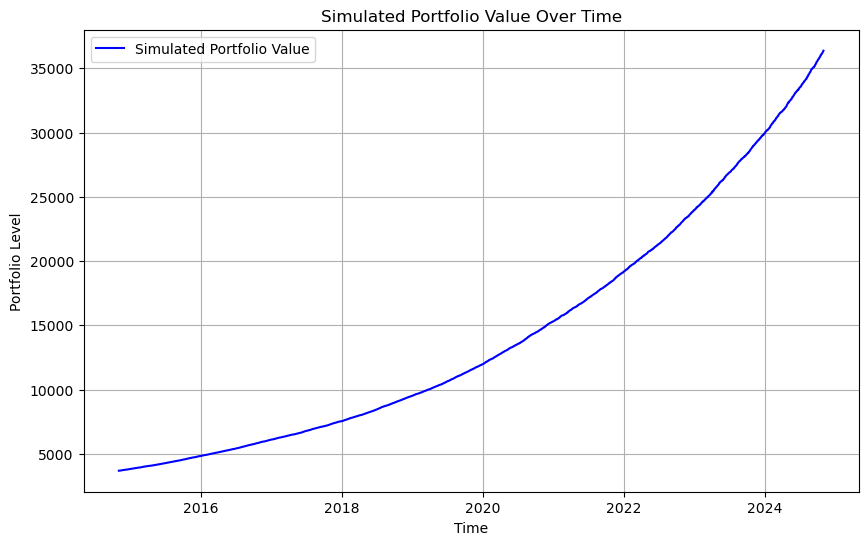

In [35]:
# Assuming the portfolio starts at a value of 100
initial_value = 3679.99  # or use initial_value = 3679.99 for SPY level
portfolio_value = initial_value * (1 + portfolio_returns_daily_df["Portfolio Returns"]).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(time, portfolio_value[:-2], label='Simulated Portfolio Value', color='b')
plt.title('Simulated Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Level')
plt.legend()
plt.grid(True)
plt.show() # too smooth to be displayed

In [36]:
portfolio_value.iloc[-1] # ends at 36K here

36431.48355800073

In [37]:
# + if we want to display the representative path of it: 
# so here we plot the representative path of each factor first (final value closer to mean)
representative_paths = {}

for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    last_avg_level = mean_paths[factor][-1]
    last_levels = SV_factors[factor]['price'][-1, :]
    differences = np.abs(last_levels - last_avg_level)
    closest_path_idx = np.argmin(differences)
    representative_paths[factor] = SV_factors[factor]['price'][:, closest_path_idx]

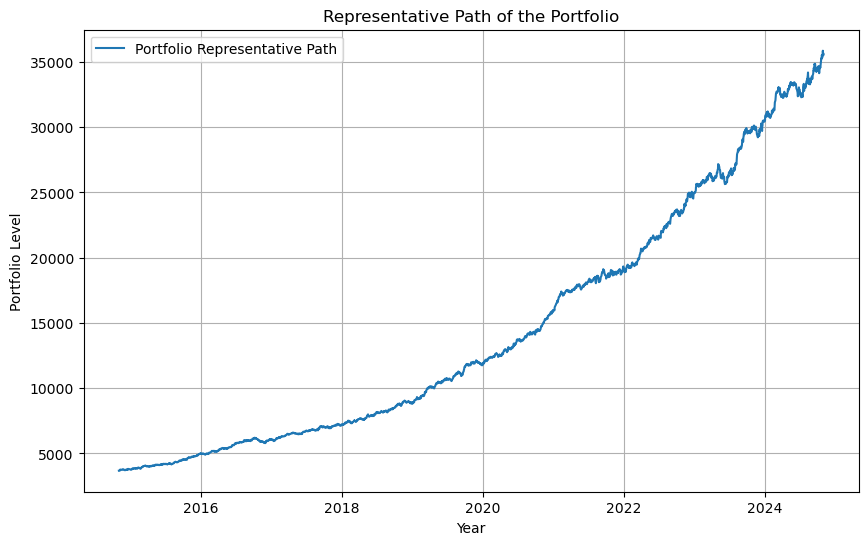

In [38]:
# Then we can get the representative path of our ptf by xing each rps path by its weight
portfolio_representative_path = np.zeros_like(representative_paths['Value'])
for i, factor in enumerate(['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']):
    portfolio_representative_path += representative_paths[factor] * weights[i]

plt.figure(figsize=(10, 6))
plt.plot(time,portfolio_representative_path[:-3], label="Portfolio Representative Path")
plt.title("Representative Path of the Portfolio")
plt.xlabel("Year")
plt.ylabel("Portfolio Level")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
portfolio_representative_path[-1] #  still close to the 36k

35651.57062328774

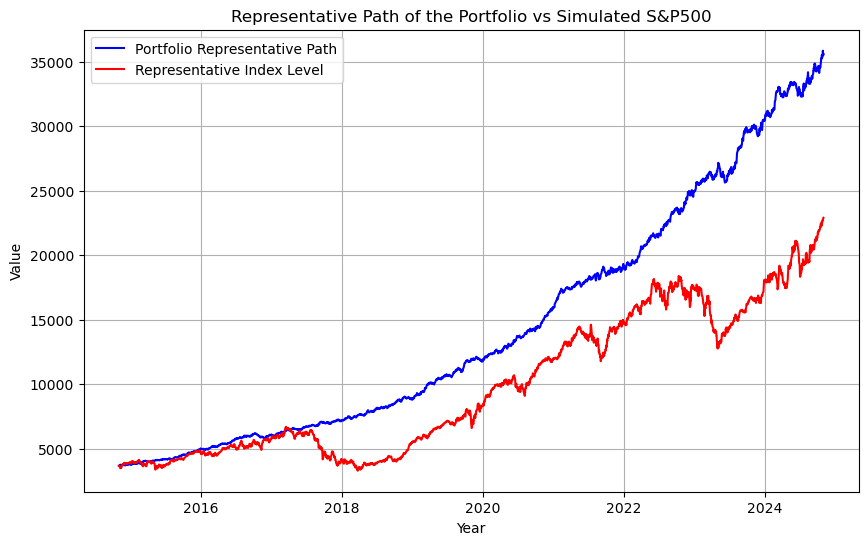

In [40]:
# Plotting one against another
plt.figure(figsize=(10, 6))
plt.plot(time, portfolio_representative_path[:-3], label="Portfolio Representative Path", color = "blue")
plt.plot(time, representative_stock_price[:-3], label='Representative Index Level', color = "red")
plt.title("Representative Path of the Portfolio vs Simulated S&P500")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show() # so big discrepancy : 35k vs 22k at the end

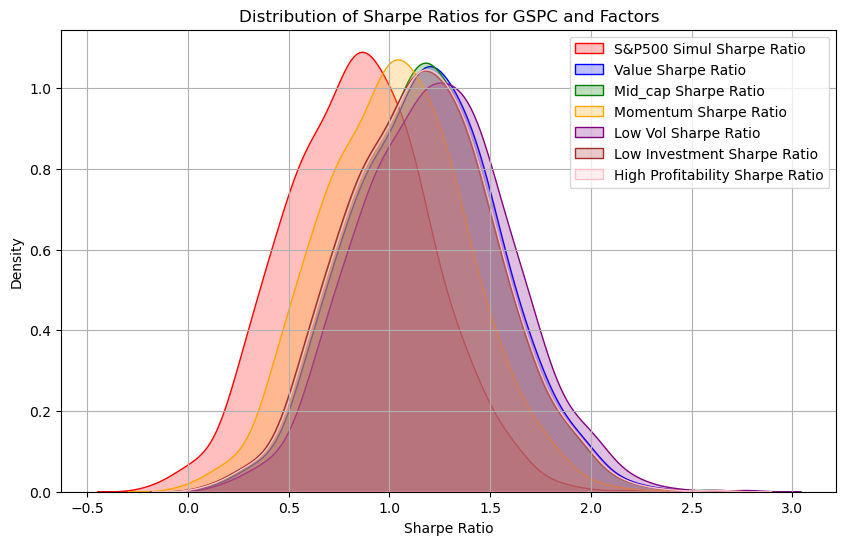

In [41]:
# Si on plot first la distribution des Sharpe Ratio du SPY et de des 6 facteurs sur ses 1000 paths
import seaborn as sns

def calculate_SR(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

sharpe_ratios_gspc = [] # Simul SP500:
for i in range(n_paths):
    simulated_returns_gspc = np.diff(np.log(SV['price'][:, i]))
    sharpe_ratios_gspc.append(calculate_SR(simulated_returns_gspc))

sharpe_ratios_factors = {} # Simul All factors
for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']:
    sharpe_ratios_factors[factor] = []
    for i in range(n_paths):
        simulated_returns_factor = np.diff(np.log(SV_factors[factor]['price'][:, i]))
        sharpe_ratios_factors[factor].append(calculate_SR(simulated_returns_factor))

plt.figure(figsize=(10, 6))
sns.kdeplot(sharpe_ratios_gspc, label='S&P500 Simul Sharpe Ratio', color='red', shade=True)

factor_colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, factor in enumerate(['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']):
    sns.kdeplot(sharpe_ratios_factors[factor], label=f'{factor} Sharpe Ratio', color=factor_colors[i], shade=True)
plt.title('Distribution of Sharpe Ratios for GSPC and Factors')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

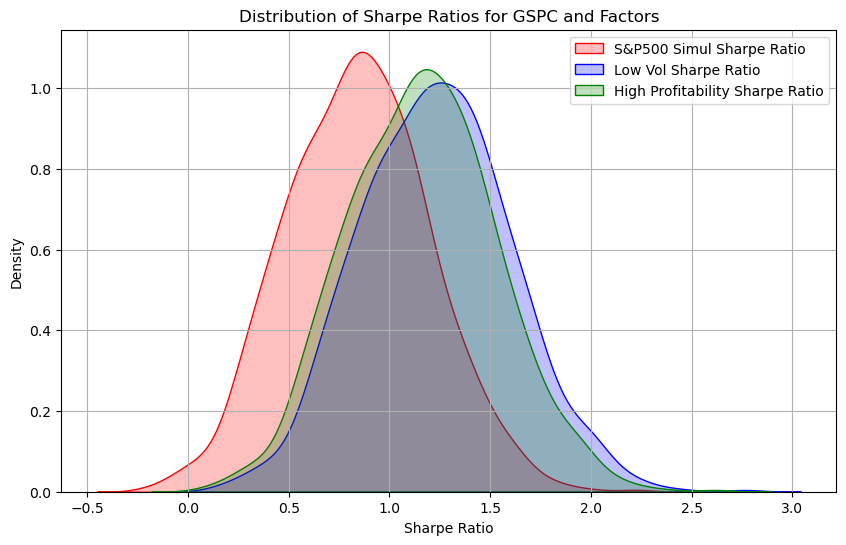

In [42]:
# Si on plot celle du SP500 et uniquement celle de Low Vol et High Profitability, les 2 facteurs primordiaux dans notre FRP:
plt.figure(figsize=(10, 6))
sns.kdeplot(sharpe_ratios_gspc, label='S&P500 Simul Sharpe Ratio', color='red', shade=True)

factor_colors = ['blue', 'green']

for i, factor in enumerate(['Low Vol','High Profitability']):
    sns.kdeplot(sharpe_ratios_factors[factor], label=f'{factor} Sharpe Ratio', color=factor_colors[i], shade=True)
plt.title('Distribution of Sharpe Ratios for GSPC and Factors')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

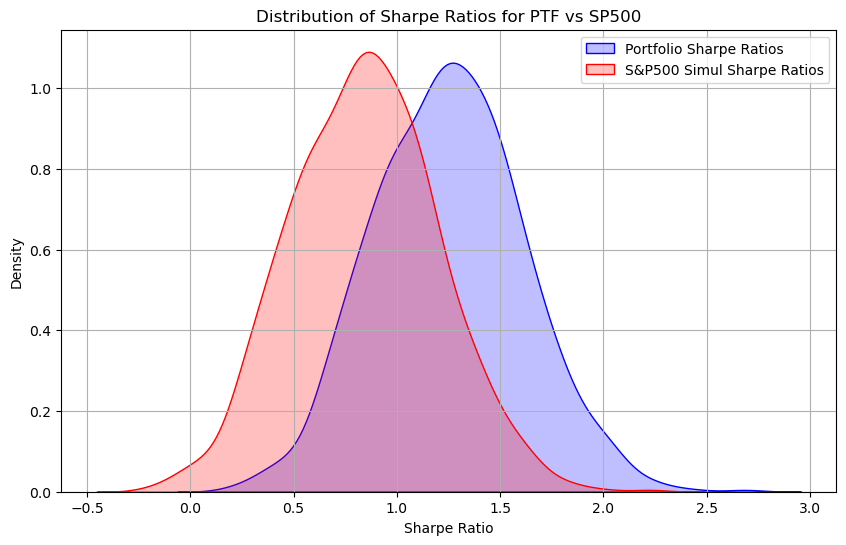

Mean Sharpe Ratio for Simulated S&P500: 0.843
Mean Sharpe Ratio for Simulated Portfolio: 1.25


In [43]:
# And if we want to plot distrib of SR simulated S&P500 with the one of ptf, using simulated_weighted_factor_ret_daily then
sharpe_ratios_paths = []

for path in range(n_paths):
    weighted_returns_for_path = np.sum(np.array([simulated_weighted_factor_ret_daily[factor][:, path] 
                                                  for factor in ['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']]), axis=0)

    sharpe_ratio_path = calculate_SR(weighted_returns_for_path)
    sharpe_ratios_paths.append(sharpe_ratio_path)

plt.figure(figsize=(10, 6))
sns.kdeplot(sharpe_ratios_paths, label='Portfolio Sharpe Ratios', shade=True, color='blue')
sns.kdeplot(sharpe_ratios_gspc, label='S&P500 Simul Sharpe Ratios', shade=True, color='red')
plt.title('Distribution of Sharpe Ratios for PTF vs SP500')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

print("Mean Sharpe Ratio for Simulated S&P500:" ,round(np.mean(sharpe_ratios_gspc),3))
print("Mean Sharpe Ratio for Simulated Portfolio:", round(np.mean(sharpe_ratios_paths),3))

In [44]:
# next step = volatility timing strategies (via GARCH, both on historical and simulated)

In [45]:
weighted_returns = []
for i, factor in enumerate(['Value', 'Mid_cap', 'Momentum', 'Low Vol', 'Low Investment', 'High Profitability']):
    weighted_returns.append(simulated_factor_ret_daily[factor].values * weights[i])

weighted_returns_array = np.array(weighted_returns)
portfolio_returns_daily = np.sum(weighted_returns_array, axis=0)
portfolio_returns_daily_df = pd.DataFrame(portfolio_returns_daily)
portfolio_returns_daily = portfolio_returns_daily_df#.set_index(risky_df[1:].index)
simulated_risky_ret_daily_psp = portfolio_returns_daily
simulated_risky_ret_daily_psp # assigning it so that we do the simulations for the PSP only

0         1         2         3         4         5         6    \
0    -0.002919 -0.004855  0.020960  0.024474  0.002715 -0.013899  0.003249   
1    -0.002157 -0.005692 -0.011327 -0.014644 -0.008114  0.017196  0.003874   
2     0.007869 -0.009705 -0.006147  0.001289 -0.005758 -0.000584 -0.000856   
3    -0.018884 -0.009192 -0.003958  0.013315 -0.001384 -0.008795  0.009806   
4     0.003198  0.025205  0.009848  0.010102  0.010267  0.001878 -0.004266   
...        ...       ...       ...       ...       ...       ...       ...   
2515 -0.003586  0.003445  0.012684  0.003272 -0.007872 -0.014291 -0.004601   
2516 -0.007610  0.013194 -0.015823  0.012127  0.020165 -0.013976 -0.011419   
2517 -0.016044 -0.008857 -0.015719  0.006080  0.038486 -0.005502  0.026089   
2518 -0.008322 -0.007568  0.011350  0.003055 -0.006017 -0.014124  0.020864   
2519  0.011984 -0.005988  0.010639  0.004475 -0.023877  0.003137 -0.001057   

           7         8         9    ...       990       991       992  \
0     0.001375 -0.009461  0.019143  ... -0.008252  0.023324 -0.007565   
1    -0.009499  0.014128  0.005696  ...  0.000760 -0.008246 -0.005201   
2     0.011781  0.021438 -0.000617  ... -0.003117  0.002801 -0.002618   
3    -0.000479  0.010530 -0.010334  ...  0.019826 -0.010744  0.002391   
4     0.000897  0.025449  0.019473  ... -0.022643  0.002639  0.012902   
...        ...       ...       ...  ...       ...       ...       ...   
2515  0.009180  0.005352 -0.011470  ...  0.004782 -0.003458 -0.022178   
2516 -0.005915  0.007330  0.007015  ...  0.002309  0.006347 -0.004121   
2517  0.001478 -0.001421  0.002640  ...  0.000476  0.004188 -0.007321   
2518  0.020392 -0.002890  0.018797  ...  0.009475  0.002072  0.010351   
2519 -0.011497  0.000991 -0.016316  ... -0.004328 -0.007116 -0.001530   

           993       994       995       996       997       998       999  
0     0.014675  0.020922 -0.000468  0.005266 -0.009903  0.007658  0.005807  
1     0.006360 -0.002006  0.024510  0.007943 -0.005221  0.027125  0.025352  
2     0.003840 -0.010128 -0.013254  0.003673 -0.003063  0.006595 -0.001834  
3     0.003875 -0.007129  0.002929  0.008243  0.015087  0.002741  0.002441  
4     0.001290  0.009663  0.017806 -0.012265  0.004221 -0.003756  0.012142  
...        ...       ...       ...       ...       ...       ...       ...  
2515 -0.003516 -0.012630  0.001434 -0.000308  0.019864  0.002668  0.011403  
2516  0.004136  0.012013  0.006041 -0.011091 -0.015147  0.025848  0.015370  
2517  0.018688 -0.021534  0.017174 -0.000690 -0.007715  0.019630 -0.005603  
2518  0.000695 -0.007547  0.002965 -0.014095  0.017452 -0.014304  0.015241  
2519  0.001475  0.010154 -0.000120  0.016333 -0.004303 -0.012036  0.005915  

[2520 rows x 1000 columns]

## Target Volatility for Simulated S&P500

In [47]:
from arch import arch_model

def garch(returns, p=1, q=1): # simple 1, 1 Garch, over the entire dataset here
    model = arch_model(returns, vol='Garch', p=p, q=q)
    model_fitted = model.fit(disp="off")
    volatility = model_fitted.conditional_volatility
    return volatility

#### For most representative path (much more representative)

In [49]:
representative_stock_price_df = pd.Series(representative_stock_price[:-3], index=time)
representative_stock_return = representative_stock_price_df.pct_change().dropna()
representative_stock_return_df = pd.Series(representative_stock_return, index=time)
representative_stock_return

Date
2014-11-03    0.000892
2014-11-04   -0.018932
2014-11-05   -0.000814
2014-11-06   -0.006399
2014-11-07   -0.025555
                ...   
2024-10-28    0.011175
2024-10-29   -0.001249
2024-10-30    0.004450
2024-10-31    0.003318
2024-11-01    0.000860
Length: 2517, dtype: float64

In [50]:
representative_stock_return.std()*np.sqrt(252) # 21% here

0.21086517675030353

In [51]:
volatility_estimates = garch(representative_stock_return)
volatility_series = pd.Series(volatility_estimates, index=representative_stock_return.index) # vol here is much more coherent than before (all paths)

In [52]:
volatility_series.mean()* np.sqrt(252)*100 # -> 19.9% vol annualized, in line with expectations

19.94803219403575

In [53]:
target_volatility = representative_stock_return.std()  # its 21% annualized
# initial_risky_allocation = 0.6  # this will see later
adjusted_allocation = (target_volatility / volatility_series) # initial_risky_allocation -> this will see later

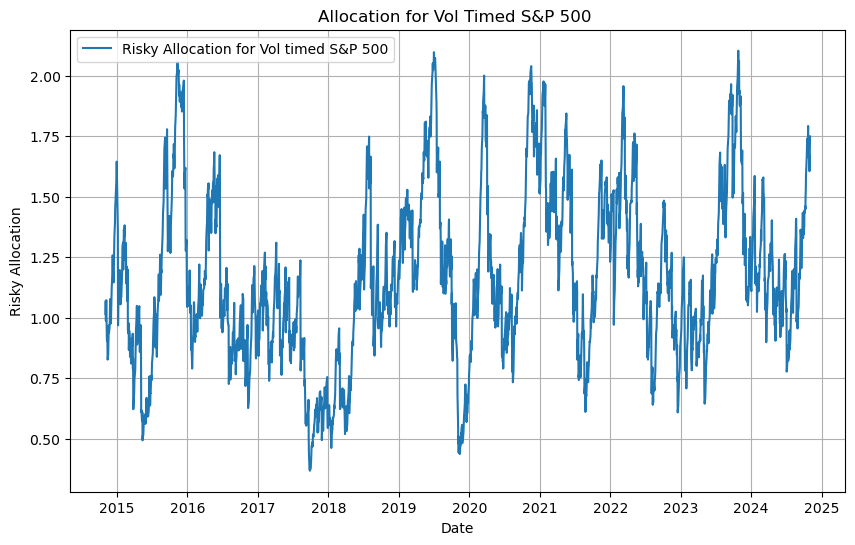

In [54]:
plt.figure(figsize=(10, 6)) # such pretty graph here
plt.plot(volatility_series.index, adjusted_allocation, label="Risky Allocation for Vol timed S&P 500")
plt.title("Allocation for Vol Timed S&P 500 ")
plt.xlabel("Date")
plt.ylabel("Risky Allocation")
plt.legend()
plt.grid(True)
plt.show()